Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 1522 columns and 3042 nonzeros
Model fingerprint: 0xca9b9574
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 2 rows and 4 columns
Presolve time: 0.00s
Presolved: 398 rows, 1518 columns, 3034 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   1.000000e+02   0.000000e+00      0s
     199    2.6000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 199 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.600000000e+01


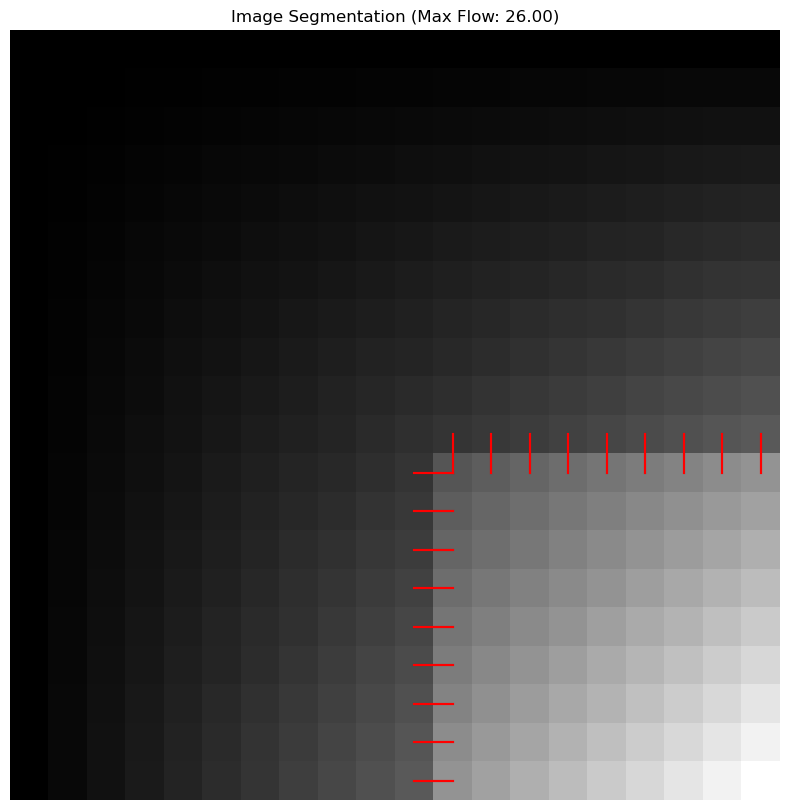

Max Flow: 26.00
Sum of cut capacities: 52.00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# Load image data from CSV
image = pd.read_csv('box.csv', header=None).values

# Set parameters
sigma = 0.05
background_pixel = (0, 0)
foreground_pixel = (19, 19)

def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    total_pixels = height * width
    edges = []
    
    # Create edges based on pixel similarity
    for i in range(height):
        for j in range(width):
            pixel = i * width + j
            neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            
            # Check neighbor pixels for edge creation
            for di, dj in neighbors:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor_pixel = ni * width + nj
                    similarity = 100 * np.exp(-((image[i, j] - image[ni, nj])**2) / (2 * sigma**2))
                    if similarity > 0:
                        edges.append((pixel, neighbor_pixel, np.ceil(similarity)))

    source = total_pixels
    sink = total_pixels + 1

    # Get maximum similarity for normalization
    max_similarity = max([edge[2] for edge in edges], default=100)

    # Add edges from source to background pixel and from foreground pixel to sink
    bg_pixel = background_pixel[0] * width + background_pixel[1]
    fg_pixel = foreground_pixel[0] * width + foreground_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    edges.append((fg_pixel, sink, max_similarity))

    return edges, total_pixels + 2  # Return the list of edges and total nodes (including source and sink)

# Create the network of edges
edges, num_nodes = create_network(image, sigma, background_pixel, foreground_pixel)

# Initialize Gurobi model for max flow problem
model = gp.Model("max_flow")

# Create flow variables for each edge
flow_vars = model.addVars(edges, name="flow")

# Maximize flow from the source
source_node = num_nodes - 2
model.setObjective(gp.quicksum(flow_vars[e] for e in edges if e[0] == source_node), GRB.MAXIMIZE)

# Flow conservation: what goes into a node must come out
for i in range(num_nodes - 2):  # Exclude source and sink
    model.addConstr(
        gp.quicksum(flow_vars[e] for e in edges if e[1] == i) ==  # Inflow
        gp.quicksum(flow_vars[e] for e in edges if e[0] == i)  # Outflow
    )

# Set flow capacity for each edge
for e in edges:
    flow_vars[e].ub = e[2]  # Capacity is the similarity value

# Solve the model
model.optimize()

# Get the flow solution
flow_solution = {e: flow_vars[e].X for e in edges}

# Build graph to find cuts based on the residual flow
graph = nx.DiGraph()
for e in edges:
    if e[2] - flow_solution[e] > 1e-6:  # Check residual capacity
        graph.add_edge(e[0], e[1])

# Find reachable nodes from the source
reachable_nodes = set(nx.dfs_preorder_nodes(graph, source=source_node))
cuts = [(u, v) for u, v, _ in edges if (u in reachable_nodes) != (v in reachable_nodes)]

# Visualize the results
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')

# Plot the cuts in red
for u, v in cuts:
    y1, x1 = divmod(u, image.shape[1])
    y2, x2 = divmod(v, image.shape[1])
    plt.plot([x1, x2], [y1, y2], 'r-')

plt.title(f'Image Segmentation (Max Flow: {model.objVal:.2f})')
plt.axis('off')
plt.show()

# Output results
print(f'Max Flow: {model.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in edges if (e[0], e[1]) in cuts):.2f}')

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 1522 columns and 3042 nonzeros
Model fingerprint: 0x31df0343
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 397 rows, 1516 columns, 3030 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   1.000000e+02   0.000000e+00      0s
     303    5.2000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 303 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.200000000e+01


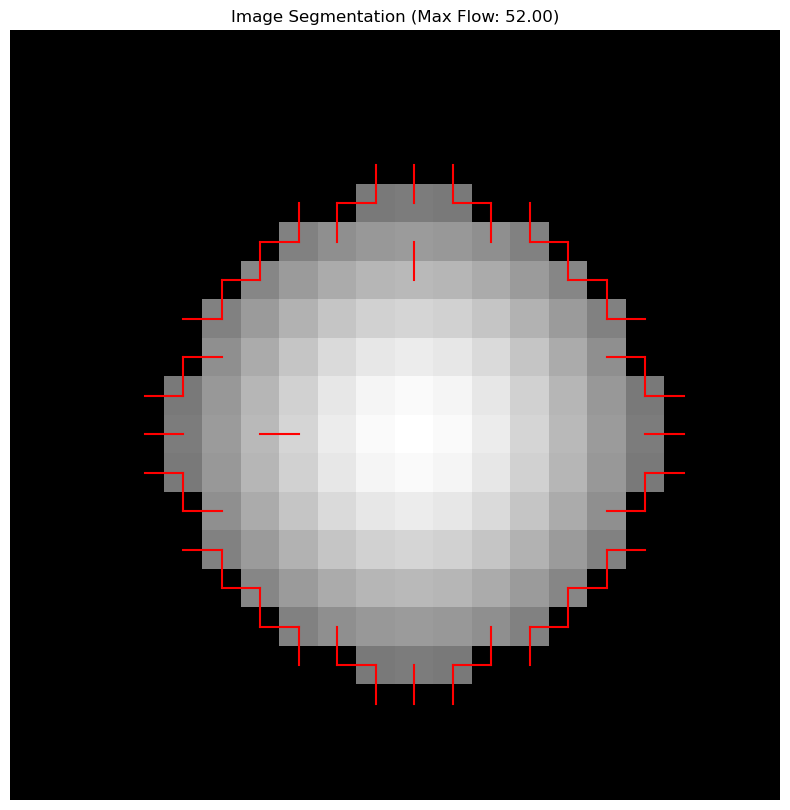

Max Flow: 52.00
Sum of cut capacities: 68.00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# Load image data
image = pd.read_csv('oval-1.csv', header=None).values

# Parameters for pixel comparison
sigma = 0.05
background_pixel = (0, 0)  # Background pixel position
foreground_pixel = (10, 10)  # Foreground pixel position

# Function to create the network of edges based on pixel similarities
def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    total_pixels = height * width
    edges = []
    
    # Loop through each pixel in the image
    for i in range(height):
        for j in range(width):
            pixel_index = i * width + j  # Get unique index for each pixel
            
            # Check the 4 neighboring pixels: up, down, left, right
            neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for di, dj in neighbors:
                ni, nj = i + di, j + dj  # Calculate neighbor coordinates
                if 0 <= ni < height and 0 <= nj < width:  # Check if neighbor is within bounds
                    neighbor_index = ni * width + nj
                    # Calculate pixel similarity using a Gaussian function
                    similarity = 100 * np.exp(-((image[i, j] - image[ni, nj])**2) / (2 * sigma**2))
                    if similarity > 0:
                        edges.append((pixel_index, neighbor_index, np.ceil(similarity)))

    # Add source and sink to connect to the background and foreground pixels
    source = total_pixels
    sink = total_pixels + 1
    max_similarity = max(edge[2] for edge in edges) if edges else 100
    
    # Connect source to the background pixel and foreground pixel to the sink
    bg_pixel = background_pixel[0] * width + background_pixel[1]
    fg_pixel = foreground_pixel[0] * width + foreground_pixel[1]
    edges.append((source, bg_pixel, max_similarity))
    edges.append((fg_pixel, sink, max_similarity))

    return edges, total_pixels + 2  # Return the edges and the total number of nodes

# Function to solve max flow problem and extract the minimum cut using Gurobi
def solve_max_flow_with_min_cut(edges, num_nodes):
    # Initialize the Gurobi model
    model = gp.Model("max_flow")
    
    # Create flow variables for the edges
    flow_vars = model.addVars(edges, name="flow")
    
    # Set the objective to maximize the flow from the source (node num_nodes-2)
    source_node = num_nodes - 2
    model.setObjective(gp.quicksum(flow_vars[e] for e in edges if e[0] == source_node), GRB.MAXIMIZE)
    
    # Add flow conservation constraints for each node except source and sink
    for i in range(num_nodes - 2):  # Exclude source and sink
        model.addConstr(
            gp.quicksum(flow_vars[e] for e in edges if e[1] == i) ==  # Inflow
            gp.quicksum(flow_vars[e] for e in edges if e[0] == i)  # Outflow
        )
    
    # Set capacity constraints for each edge
    for e in edges:
        flow_vars[e].ub = e[2]  # Capacity of each edge is the similarity value

    # Solve the max flow problem
    model.optimize()

    # Extract the flow solution
    flow_solution = {e: flow_vars[e].X for e in edges}
    
    # Find edges in the minimum cut (where flow is close to capacity)
    min_cut_edges = [e for e in edges if flow_solution[e] >= e[2] - 1e-6]

    return model, flow_solution, min_cut_edges

# Main execution
edges, num_nodes = create_network(image, sigma, background_pixel, foreground_pixel)

# Solve the max flow problem and get the minimum cut edges
model, flow_solution, min_cut_edges = solve_max_flow_with_min_cut(edges, num_nodes)

# Visualize the results (draw the cuts in red)
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
for u, v, _ in min_cut_edges:
    y1, x1 = divmod(u, image.shape[1])
    y2, x2 = divmod(v, image.shape[1])
    plt.plot([x1, x2], [y1, y2], 'r-')

plt.title(f'Image Segmentation (Max Flow: {model.objVal:.2f})')
plt.axis('off')
plt.show()

# Print the result
print(f'Max Flow: {model.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in min_cut_edges):.2f}')

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 1522 columns and 3042 nonzeros
Model fingerprint: 0xcbffc466
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolved: 397 rows, 1516 columns, 3030 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   1.000000e+02   0.000000e+00      0s
     351    3.8000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 351 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.800000000e+01


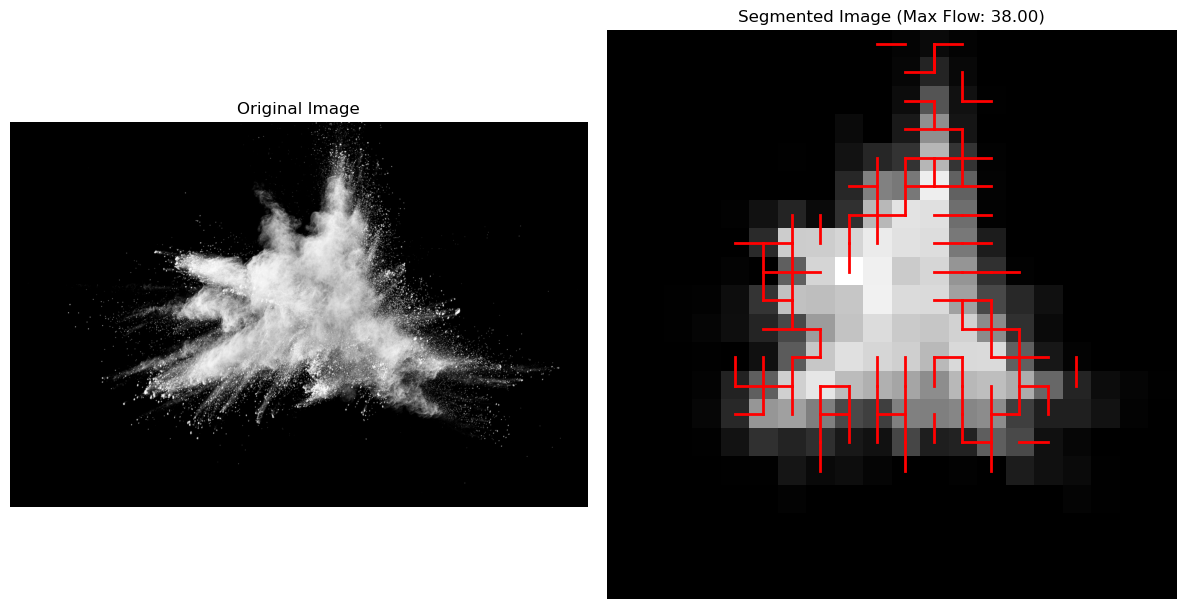

Max Flow: 38.00
Sum of cut capacities: 506.00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from PIL import Image

# Function to load and preprocess image data
def load_image(file_path):
    """
    Load the image, convert to grayscale, resize to 20x20 pixels, and normalize pixel values to [0, 1].
    """
    img = Image.open(file_path).convert('L')  # Convert to grayscale
    original_img = np.array(img)  # Keep the original image for display
    img = img.resize((20, 20))  # Resize to 20x20 pixels
    img_data = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return original_img, img_data

# Parameters for pixel similarity calculation
sigma = 0.05
background_pixel = (0, 0)  # Background pixel position
foreground_pixel = (10, 10)  # Foreground pixel position

# Function to create the network of edges based on pixel similarities
def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    total_pixels = height * width
    edges = []

    # Create edges between neighboring pixels based on similarity
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Neighbor directions: up, down, left, right
    for i in range(height):
        for j in range(width):
            pixel_index = i * width + j
            for di, dj in neighbors:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor_index = ni * width + nj
                    similarity = 100 * np.exp(-((image[i, j] - image[ni, nj])**2) / (2 * sigma**2))
                    if similarity > 0:
                        edges.append((pixel_index, neighbor_index, np.ceil(similarity)))

    # Add source and sink to the graph
    source, sink = total_pixels, total_pixels + 1
    max_similarity = max([edge[2] for edge in edges], default=100)
    
    # Connect source to background pixel, and foreground pixel to sink
    bg_pixel_index = background_pixel[0] * width + background_pixel[1]
    fg_pixel_index = foreground_pixel[0] * width + foreground_pixel[1]
    edges.append((source, bg_pixel_index, max_similarity))
    edges.append((fg_pixel_index, sink, max_similarity))

    return edges, total_pixels + 2  # Return edges and total number of nodes (including source and sink)

# Function to solve the max flow problem and find the minimum cut
def solve_max_flow_with_min_cut(edges, num_nodes):
    model = gp.Model("max_flow")

    # Create flow variables for edges
    flow_vars = model.addVars(edges, name="flow")

    # Maximize flow from the source (node num_nodes-2)
    source_node = num_nodes - 2
    model.setObjective(gp.quicksum(flow_vars[e] for e in edges if e[0] == source_node), GRB.MAXIMIZE)

    # Add flow conservation constraints for all nodes (except source and sink)
    for i in range(num_nodes - 2):
        model.addConstr(
            gp.quicksum(flow_vars[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow_vars[e] for e in edges if e[0] == i)
        )

    # Set capacity constraints for each edge
    for e in edges:
        flow_vars[e].ub = e[2]  # Edge capacity

    # Solve the model (optimize)
    model.optimize()

    # Extract flow solution
    flow_solution = {e: flow_vars[e].X for e in edges}

    # Identify minimum cut edges (where flow is saturated)
    min_cut_edges = [e for e in edges if flow_solution[e] >= e[2] - 1e-6]

    return model, flow_solution, min_cut_edges

# Main execution
image_file_path = 'Sample 3.jpg'  # Replace with your image file path
original_image, image = load_image(image_file_path)  # Load and resize the image

# Create network of edges based on the resized image
edges, num_nodes = create_network(image, sigma, background_pixel, foreground_pixel)

# Solve max flow and find the minimum cut
model, flow_solution, min_cut_edges = solve_max_flow_with_min_cut(edges, num_nodes)

# Visualize the original and segmented images
plt.figure(figsize=(12, 6))

# Plot original image (left)
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Plot segmented image with cut (right)
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
for u, v, _ in min_cut_edges:
    y1, x1 = divmod(u, image.shape[1])
    y2, x2 = divmod(v, image.shape[1])
    plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # Red lines for cut
plt.title(f'Segmented Image (Max Flow: {model.objVal:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print max flow and sum of cut capacities
print(f'Max Flow: {model.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in min_cut_edges):.2f}')

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 1230 columns and 2458 nonzeros
Model fingerprint: 0x1bcd94ca
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 91 rows and 87 columns
Presolve time: 0.00s
Presolved: 309 rows, 1143 columns, 2285 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   1.000000e+02   0.000000e+00      0s
     243   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 243 iterations and 0.01 seconds (0.00 work units)
Optimal objective -0.000000000e+00


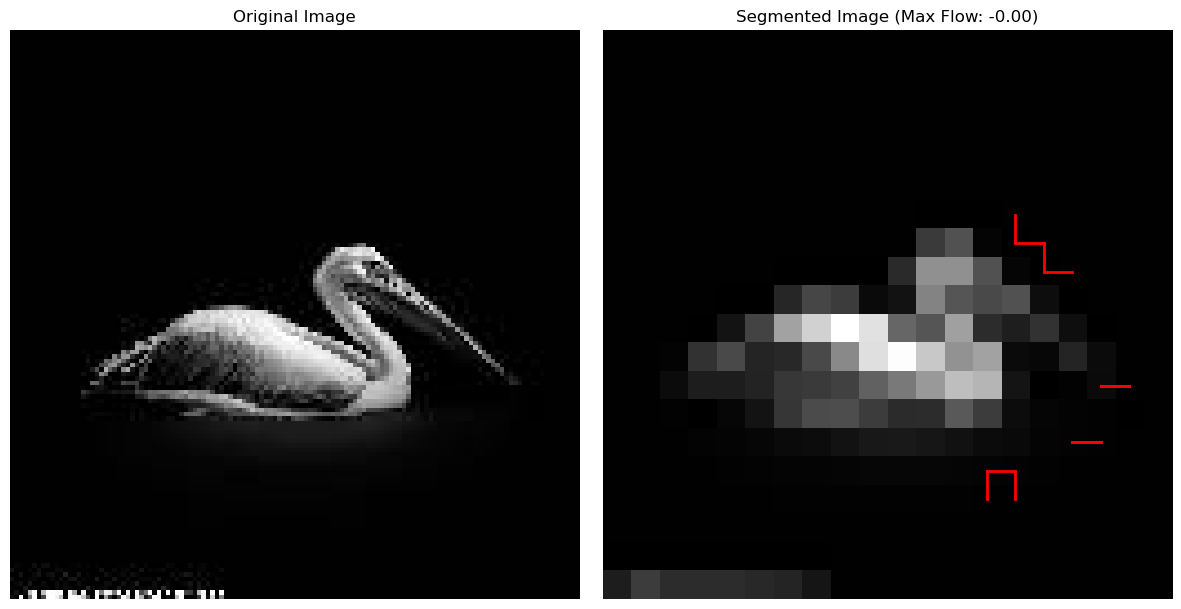

Max Flow: -0.00
Sum of cut capacities: 11.00


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from PIL import Image

# Function to load and preprocess image data
def load_image(file_path):
    """
    Load the image, convert to grayscale, resize to 20x20 pixels, and normalize pixel values to [0, 1].
    """
    img = Image.open(file_path).convert('L')  # Convert to grayscale
    original_img = np.array(img)  # Keep the original image for display
    img = img.resize((20, 20))  # Resize to 20x20 pixels
    img_data = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return original_img, img_data

# Parameters for pixel similarity calculation
sigma = 0.001
background_pixel = (0, 0)  # Background pixel position
foreground_pixel = (10, 10)  # Foreground pixel position

# Function to create the network of edges based on pixel similarities
def create_network(image, sigma, background_pixel, foreground_pixel):
    height, width = image.shape
    total_pixels = height * width
    edges = []

    # Create edges between neighboring pixels based on similarity
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Neighbor directions: up, down, left, right
    for i in range(height):
        for j in range(width):
            pixel_index = i * width + j
            for di, dj in neighbors:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    neighbor_index = ni * width + nj
                    similarity = 100 * np.exp(-((image[i, j] - image[ni, nj])**2) / (2 * sigma**2))
                    if similarity > 0:
                        edges.append((pixel_index, neighbor_index, np.ceil(similarity)))

    # Add source and sink to the graph
    source, sink = total_pixels, total_pixels + 1
    max_similarity = max([edge[2] for edge in edges], default=100)
    
    # Connect source to background pixel, and foreground pixel to sink
    bg_pixel_index = background_pixel[0] * width + background_pixel[1]
    fg_pixel_index = foreground_pixel[0] * width + foreground_pixel[1]
    edges.append((source, bg_pixel_index, max_similarity))
    edges.append((fg_pixel_index, sink, max_similarity))

    return edges, total_pixels + 2  # Return edges and total number of nodes (including source and sink)

# Function to solve the max flow problem and find the minimum cut
def solve_max_flow_with_min_cut(edges, num_nodes):
    model = gp.Model("max_flow")

    # Create flow variables for edges
    flow_vars = model.addVars(edges, name="flow")

    # Maximize flow from the source (node num_nodes-2)
    source_node = num_nodes - 2
    model.setObjective(gp.quicksum(flow_vars[e] for e in edges if e[0] == source_node), GRB.MAXIMIZE)

    # Add flow conservation constraints for all nodes (except source and sink)
    for i in range(num_nodes - 2):
        model.addConstr(
            gp.quicksum(flow_vars[e] for e in edges if e[1] == i) ==
            gp.quicksum(flow_vars[e] for e in edges if e[0] == i)
        )

    # Set capacity constraints for each edge
    for e in edges:
        flow_vars[e].ub = e[2]  # Edge capacity

    # Solve the model (optimize)
    model.optimize()

    # Extract flow solution
    flow_solution = {e: flow_vars[e].X for e in edges}

    # Identify minimum cut edges (where flow is saturated)
    min_cut_edges = [e for e in edges if flow_solution[e] >= e[2] - 1e-6]

    return model, flow_solution, min_cut_edges

# Main execution
image_file_path = 'Pic3.jpg'  # Replace with your image file path
original_image, image = load_image(image_file_path)  # Load and resize the image

# Create network of edges based on the resized image
edges, num_nodes = create_network(image, sigma, background_pixel, foreground_pixel)

# Solve max flow and find the minimum cut
model, flow_solution, min_cut_edges = solve_max_flow_with_min_cut(edges, num_nodes)

# Visualize the original and segmented images
plt.figure(figsize=(12, 6))

# Plot original image (left)
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Plot segmented image with cut (right)
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
for u, v, _ in min_cut_edges:
    y1, x1 = divmod(u, image.shape[1])
    y2, x2 = divmod(v, image.shape[1])
    plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)  # Red lines for cut
plt.title(f'Segmented Image (Max Flow: {model.objVal:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print max flow and sum of cut capacities
print(f'Max Flow: {model.objVal:.2f}')
print(f'Sum of cut capacities: {sum(e[2] for e in min_cut_edges):.2f}')